In [ ]:
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from joblib import dump, load
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import tree
import numpy as np
import itertools
from sklearn.naive_bayes import GaussianNB
from sklearn import neighbors
from sklearn.ensemble import RandomForestClassifier

'''
Disclaimer: the following code is adapted from 
https://github.com/parthpatwa/covid19-fake-news-detection

@misc{patwa2020fighting,
title={Fighting an Infodemic: COVID-19 Fake News Dataset}, 
author={Parth Patwa and Shivam Sharma and Srinivas PYKL and Vineeth Guptha and Gitanjali Kumari and Md Shad Akhtar and Asif Ekbal and Amitava Das and Tanmoy Chakraborty},
year={2020},
eprint={2011.03327},
archivePrefix={arXiv},
primaryClass={cs.CL}
}
'''

'\nDisclaimer: the following code is adapted from \nhttps://github.com/parthpatwa/covid19-fake-news-detection\n\n@misc{patwa2020fighting,\ntitle={Fighting an Infodemic: COVID-19 Fake News Dataset}, \nauthor={Parth Patwa and Shivam Sharma and Srinivas PYKL and Vineeth Guptha and Gitanjali Kumari and Md Shad Akhtar and Asif Ekbal and Amitava Das and Tanmoy Chakraborty},\nyear={2020},\neprint={2011.03327},\narchivePrefix={arXiv},\nprimaryClass={cs.CL}\n}\n'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
# lazy install stopwords and jieba
nltk.download('stopwords')
!pip install stopwordsiso
import stopwordsiso as stopwords

!pip install jieba 
import jieba
import jieba.posseg as pseg

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     |████████████████████████████████| 81kB 3.6MB/s 


In [ ]:
# data cleaning and splitting
def clear_character(sentence):
    pattern1='[a-zA-Z0-9]'
    pattern2 = '\[.*?\]'
    pattern3 = re.compile(u'[^\s1234567890:：' + '\u4e00-\u9fa5]+')
    pattern4='[’!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]+'
    line1=re.sub(pattern1,'', str(sentence))   # removing the number and english
    line2=re.sub(pattern2,'', str(line1))   # removing emoji
    line3=re.sub(pattern3,'', str(line2))   # romoving other punctuation
    line4=re.sub(pattern4, '', str(line3)) # romoving other punctuation
    new_sentence=''.join(line4.split()) # removing space
    return new_sentence


def text_clean(contents):
    contents = clear_character(contents)  
    contents = jieba.lcut(contents)
    sentence=' '.join(contents)
    return sentence


In [ ]:
# load dataset
train = pd.read_csv('/content/drive/MyDrive/chinese_train.csv')
val = pd.read_csv('/content/drive/MyDrive/chinese_validate.csv')
test = pd.read_csv('/content/drive/MyDrive/chinese_test.csv')

In [ ]:
# clean dataset
train['text'] = train['text'].map(lambda x: text_clean(x))
val['text'] = val['text'].map(lambda x: text_clean(x))
test['text'] = test['text'].map(lambda x: text_clean(x))

In [ ]:
def print_metrices(pred,true):
    print(confusion_matrix(true,pred))
    print(classification_report(true,pred,))
    print("Accuracy : ",accuracy_score(pred,true))
    print("Precison : ",precision_score(pred,true, average = 'weighted'))
    print("Recall : ",recall_score(pred,true,  average = 'weighted'))
    print("F1 : ",f1_score(pred,true,  average = 'weighted'))
    
    

Logistic Regression
test:
[[3178  258]
 [  32 3429]]
              precision    recall  f1-score   support

           0       0.99      0.92      0.96      3436
           1       0.93      0.99      0.96      3461

    accuracy                           0.96      6897
   macro avg       0.96      0.96      0.96      6897
weighted avg       0.96      0.96      0.96      6897

Accuracy :  0.9579527330723503
Precison :  0.9601102164358724
Recall :  0.9579527330723503
F1 :  0.9580029413185797


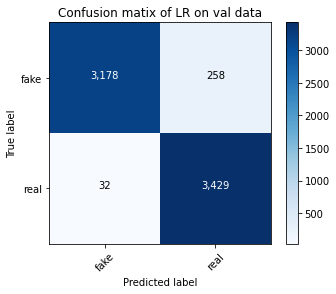

In [ ]:
# Running Logistic Regression
pipeline = Pipeline([
        ('bow', CountVectorizer()),  
        ('tfidf', TfidfTransformer()),  
        ('c', LogisticRegression())
    ])
fit = pipeline.fit(train['text'],train['label'])
print('Logistic Regression')
print ('test:')
pred=pipeline.predict(test['text'])
print_metrices(pred,test['label'])
plot_confusion_matrix(confusion_matrix(test['label'],pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matrix of LR on val data')


Gradient Boost
test:
[[2619  817]
 [ 115 3346]]
              precision    recall  f1-score   support

           0       0.96      0.76      0.85      3436
           1       0.80      0.97      0.88      3461

    accuracy                           0.86      6897
   macro avg       0.88      0.86      0.86      6897
weighted avg       0.88      0.86      0.86      6897

Accuracy :  0.8648687835290706
Precison :  0.8856884824614057
Recall :  0.8648687835290706
F1 :  0.8663348685538156


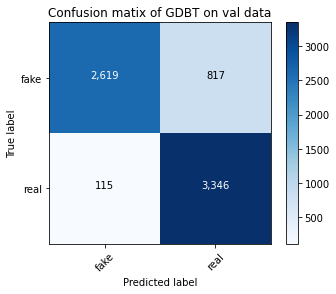

In [ ]:
# Running Gradient Boost
# May have minor variations due to randomness
pipeline = Pipeline([
        ('bow', CountVectorizer()),  
        ('tfidf', TfidfTransformer()),  
        ('c', GradientBoostingClassifier())
    ])
fit = pipeline.fit(train['text'],train['label'])
print('Gradient Boost')
print ('test:')
pred=pipeline.predict(test['text'])
print_metrices(pred,test['label'])
plot_confusion_matrix(confusion_matrix(test['label'],pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matrix of GDBT on val data')

Decision Tree
test:
[[3204  233]
 [ 287 3174]]
              precision    recall  f1-score   support

           0       0.92      0.93      0.92      3437
           1       0.93      0.92      0.92      3461

    accuracy                           0.92      6898
   macro avg       0.92      0.92      0.92      6898
weighted avg       0.92      0.92      0.92      6898

Accuracy :  0.9246158306755581
Precison :  0.9247342919552113
Recall :  0.9246158306755581
F1 :  0.9246183972685416


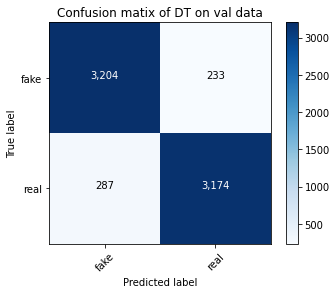

In [ ]:
# Running Decision Tree
# May have minor variations due to randomness

pipeline = Pipeline([
        ('bow', CountVectorizer()),  
        ('tfidf', TfidfTransformer()),  
        ('c', tree.DecisionTreeClassifier())
    ])
fit = pipeline.fit(train['text'],train['label'])

print('Decision Tree')
print ('test:')
pred=pipeline.predict(val['text'])

print_metrices(pred, val['label'])
plot_confusion_matrix(confusion_matrix(val['label'],pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matrix of DT on val data')

Random Forest
test:
[[3237  200]
 [  56 3405]]
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      3437
           1       0.94      0.98      0.96      3461

    accuracy                           0.96      6898
   macro avg       0.96      0.96      0.96      6898
weighted avg       0.96      0.96      0.96      6898

Accuracy :  0.9628877935633517
Precison :  0.9637647779358497
Recall :  0.9628877935633517
F1 :  0.9629066734703992


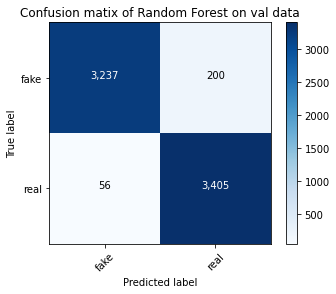

In [ ]:
# Running Random Forest
# May have minor variations due to randomness

pipeline = Pipeline([
        ('bow', CountVectorizer()),  
        ('tfidf', TfidfTransformer()),  
        ('c', RandomForestClassifier())
    ])
fit = pipeline.fit(train['text'],train['label'])

print('Random Forest')
print ('test:')
pred=pipeline.predict(val['text'])

print_metrices(pred,val['label'])
plot_confusion_matrix(confusion_matrix(val['label'],pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matrix of Random Forest on val data')
